In [1]:
%load_ext tensorboard 

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import datetime

from os.path                                 import dirname
from tensorflow.keras.applications.resnet50  import ResNet50
from tensorflow.keras.applications.densenet  import DenseNet121
from tensorflow.keras                        import Sequential, layers, Model
from tensorflow.keras.callbacks              import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from sklearn.metrics                         import classification_report, accuracy_score

from dataload                                import *
from util                                    import *

In [2]:
path = "C:/Users/mvidy/Documents/data/av/emergency_vehicle_detection/"

In [3]:
loader = DataLoader(path+"train/images/", path)

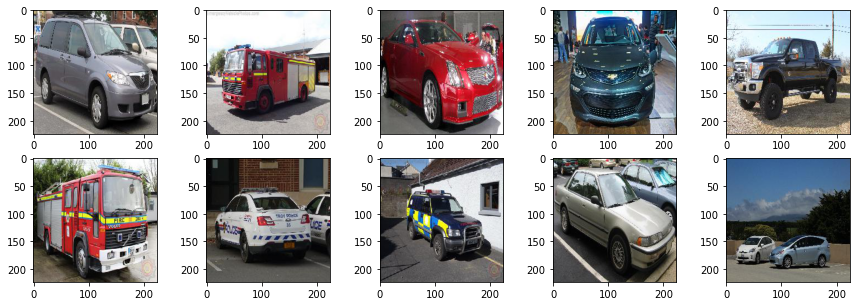

In [4]:
loader.display_samples(grid=(2, 5), figsize=(15, 5))

In [5]:
train_dataset, val_dataset, test_dataset = loader.train_test_split(train_split=0.75, batch_size=64)

In [6]:
data_aug = Sequential([
    layers.ZeroPadding2D(3),
    layers.experimental.preprocessing.RandomFlip(),
    layers.experimental.preprocessing.RandomTranslation((-0.05, 0.05), (-0.05, 0.05), fill_mode="constant"),
    layers.experimental.preprocessing.RandomZoom((-0.1, 0.1)),
    layers.experimental.preprocessing.RandomRotation((-0.1, 0.1)),
#     layers.experimental.preprocessing.Rescaling(1./255)
#     layers.experimental.preprocessing.RandomContrast(0.90),
])

preprocess = tf.keras.applications.resnet50.preprocess_input
# preprocess = tf.keras.applications.densenet.preprocess_input

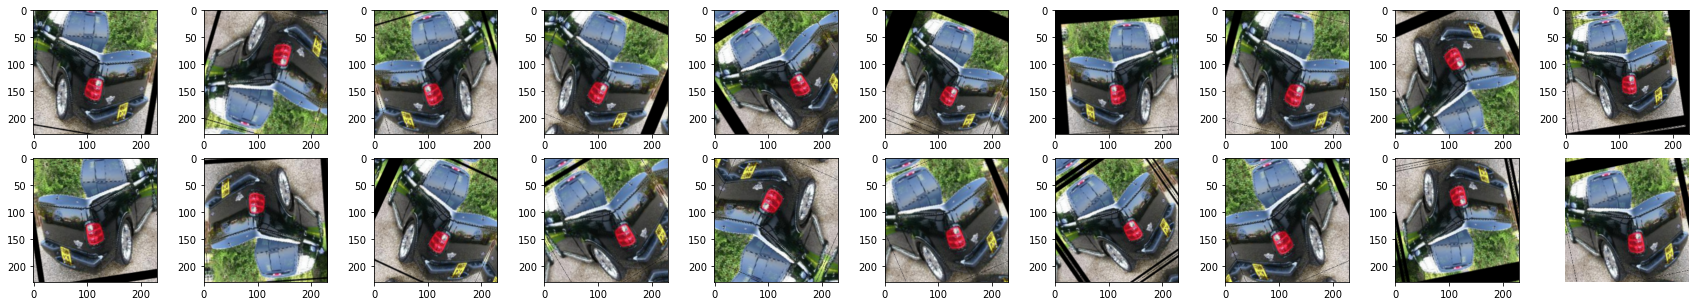

In [7]:
display_augmented(train_dataset, data_aug, preprocess=None, dtype=None)

In [8]:
base_model = ResNet50(include_top=False, input_shape=loader.image_size, classes=2)
# base_model = DenseNet121(include_top=False, input_shape=loader.image_size, classes=2)

In [9]:
base_model.trainable = False

In [10]:
clf_layers = Sequential([
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
])

In [11]:
inputs = tf.keras.Input(shape=loader.image_size)
x = data_aug(inputs)
x = preprocess(inputs)
x = base_model(x)
outputs = clf_layers(x)

model = Model(inputs, outputs)

In [12]:
base_lr = 0.001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_lr),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=["accuracy"])

In [13]:
print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 524801    
Total params: 24,112,513
Trainable params: 524,801
Non-trainable params: 23,587,712
_________________________________________________________________
None


In [14]:
cp_path = dirname("./models/cp.ckpt")
cp_callback = ModelCheckpoint(filepath=cp_path, save_weights_only=True, 
                              save_best_only=True, monitor="val_accuracy")

es_callback = EarlyStopping(monitor="val_accuracy", patience=7, verbose=1, baseline=0.90)
lr_callback = LearningRateScheduler(schedule=scheduler, verbose=5)

callbacks = [cp_callback, es_callback, lr_callback]

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [15]:
epochs = 50

model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, shuffle=True,
                    use_multiprocessing=True, workers=6, callbacks=[callbacks, tensorboard_callback])


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/50
 1/20 [>.............................] - ETA: 0s - loss: 1.1195 - accuracy: 0.3594WARNING:tensorflow:From C:\Users\mvidy\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
20/20 [==============================] - 77s 4s/step - loss: 0.3814 - accuracy: 0.8355 - val_loss: 0.1835 - val_accuracy: 0.9227

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/50
20/20 [==============================] - 77s 4s/step - loss: 0.1916 - accuracy: 0.9263 - val_loss: 0.2141 - val_accuracy: 0.9372

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/50
20/20 [==============================] - 86s 4s/step - loss: 0.1619 - accuracy: 0.9344 - v

In [16]:
print(model.evaluate(test_dataset), model.evaluate(train_dataset), model.evaluate(val_dataset))

4/4 [==============================] - 9s 2s/step - loss: 0.0170 - accuracy: 0.9952
[0.03893321380019188, 0.9804878234863281] [0.028570067137479782, 0.9935170412063599] [0.016996268182992935, 0.9951691031455994]


In [60]:
submissions = pd.read_csv(path+"/sample_submission.csv")

In [61]:
unlabelled_images = []
for image in submissions.image_names:
    unlabelled_images.append(np.asarray(Image.open("{}train/images/{}".format(path, image))))

In [62]:
unlabelled_dataset = tf.data.Dataset.from_tensor_slices(unlabelled_images)

In [70]:
preds = model.predict(unlabelled_dataset.batch(64))

In [71]:
(preds.flatten() > 0.5).astype(int)

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,

In [72]:
submissions.assign(emergency_or_not=(preds.flatten() > 0.5).astype(int)).to_csv(path+"/sample_submission.csv", index=None)

In [68]:
model.load_weights(cp_path)

In [69]:
model.evaluate(test_dataset)

4/4 [==============================] - 8s 2s/step - loss: 0.0578 - accuracy: 0.9854


[0.05780485272407532, 0.9853658676147461]

## Fine Tuning the model

In [80]:
fine_tune_at = 150
base_model.trainable = True

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [81]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_lr / 10),
              metrics=['accuracy'])

In [82]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 524801    
Total params: 24,112,513
Trainable params: 10,514,945
Non-trainable params: 13,597,568
_________________________________________________________________


In [84]:
model.evaluate(val_dataset)

4/4 [==============================] - 8s 2s/step - loss: 0.0260 - accuracy: 0.9952


[0.02596867084503174, 0.9951691031455994]

In [85]:
fine_tune_epochs = 10

model.fit(train_dataset, epochs=fine_tune_epochs, validation_data=val_dataset, shuffle=True,
          use_multiprocessing=True, workers=6, callbacks=[callbacks, tensorboard_callback])


Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 1/10
20/20 [==============================] - 185s 9s/step - loss: 0.1209 - accuracy: 0.9571 - val_loss: 0.0243 - val_accuracy: 0.9903

Epoch 00002: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 2/10
20/20 [==============================] - 184s 9s/step - loss: 0.0358 - accuracy: 0.9895 - val_loss: 0.0476 - val_accuracy: 0.9903

Epoch 00003: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 3/10
20/20 [==============================] - 187s 9s/step - loss: 0.0240 - accuracy: 0.9927 - val_loss: 0.0667 - val_accuracy: 0.9807

Epoch 00004: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 4/10
20/20 [==============================] - 179s 9s/step - loss: 0.0158 - accuracy: 0.9935 - val_loss: 0.0358 - val_accuracy: 0.9807

Epoch 00005: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 5/10


In [87]:
model.evaluate(test_dataset)

4/4 [==============================] - 7s 2s/step - loss: 0.0051 - accuracy: 1.0000


[0.005103813949972391, 1.0]

In [89]:
preds = model.predict(unlabelled_dataset.batch(64))

submissions.assign(emergency_or_not=(preds.flatten() > 0.5).astype(int)).to_csv(path+"/sample_submission.csv", index=None)